In [14]:
%load_ext autoreload
%autoreload 2

import torch, datetime, click
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
from utils import *

DEVICE = 'cuda'


# @click.command()
# @click.option("--m",    type=int, default = 12,  help="Exponent of subhalo mass.")
# @click.option("--nsub", type=int, default = 1,   help="Number of subhaloes.")
# @click.option("--nsim", type=int, default = 100, help="Number of simulations to run.")

# @click.option("--nmbins",  type=int, default = 2,   help="Number of mass bins.")

# @click.option("--lr",         type=float, default = 1e-3, help="Learning rate.")
# @click.option("--factor",     type=float, default = 1e-1, help = "Factor of Scheduler")
# @click.option("--patience",   type=int,   default = 5,    help = "Patience of Scheduler")
# @click.option("--max_epochs", type=int,   default = 30,   help = "Max number of epochs.")



m = 1
nsub = 3
nsim = 25000

nmbins = 2

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
time_start = datetime.datetime.now()

# Set definitions (should go to click)
system_name = "ngc4414"

# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

# torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(system_name, str(nsub), str(m))
# torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(CONFIG)
L = CONFIG.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)

Store _M_m1_nsub3_nsim25000 exists!
Loading existing store.
Store has 25367 simulations.
Image has L = 40.


RuntimeError: Store does not contain enough samples for your requested intensity function `N * prior`.

In [11]:
# Train
mre_name, mre_path = get_mre_path(sim_name, nmbins, lr, factor, patience)
print(f'Training {mre_name}!')

Training UNet_M_m0_nsub3_nsim200_nmbins2_lr-3.0_fac-1.0_pat5.pt!


In [12]:
torch.set_default_tensor_type(torch.FloatTensor)


# def get_custom_marginal_classifier(
#     observation_transform,
#     marginal_indices: tuple,
#     nmbins, 
#     lows,
#     highs,
#     marginal_classifier,
#     parameter_online_z_score: bool = False
# ) -> torch.nn.Module:
    
#     n_observation_features = observation_transform.n_features
    
#     parameter_transform = CustomParameterTransform(nmbins, L, lows, highs)

#     marginal_classifier = marginal_classifier(
#         len(marginal_indices),
#         n_observation_features,
#         nmbins
#     )

#     return swyft.networks.Network(
#         observation_transform,
#         parameter_transform,
#         marginal_classifier,
#     )
    

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmbins, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator(
    marginal_indices = marginal_indices,
    network = network,
    device = DEVICE,
)

_ = mre.train(dataset, max_epochs = max_epochs)
mre.save(mre_path)
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK


training: lr=0.0005, epoch=5, validation loss=8915


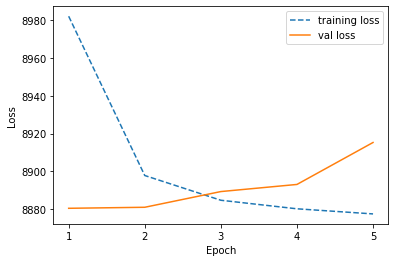

In [13]:
plot_losses(mre)

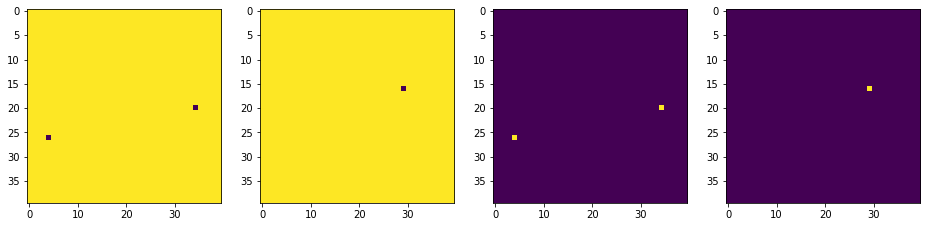

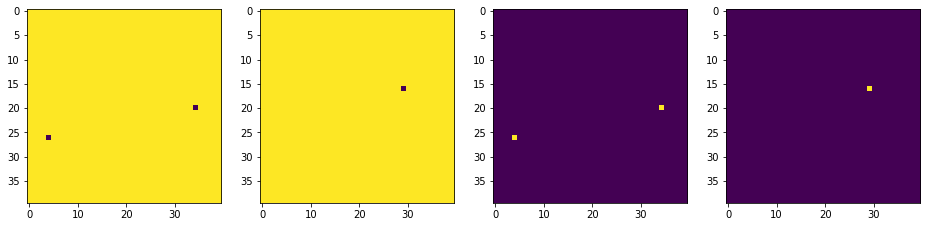

v0


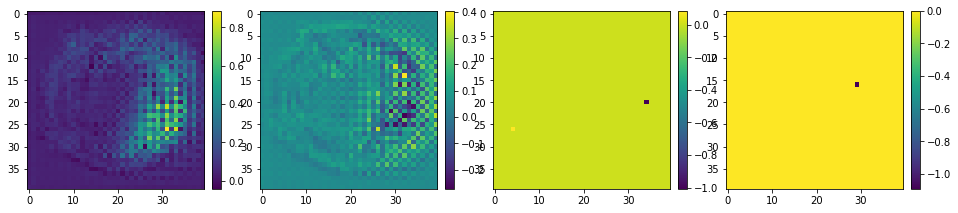

coord 0


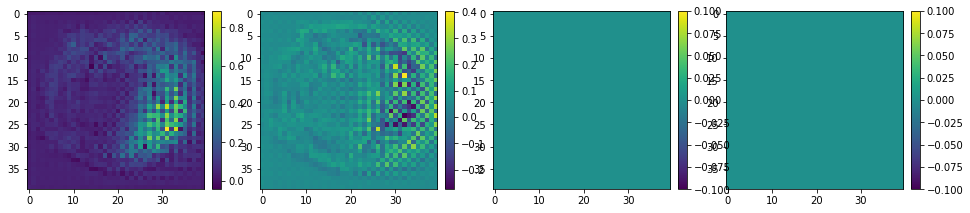

coord 1


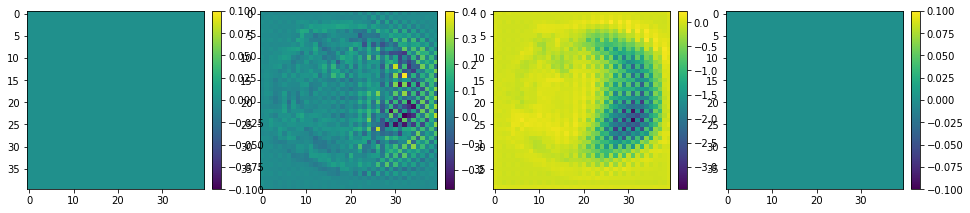

coord 2


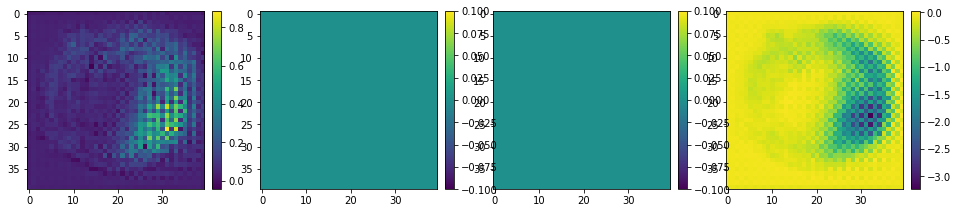

In [15]:
i = 0
obs0 = store[i][0]
v0 = store[i][1]

obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
v0 = tensor(v0).unsqueeze(0).to(DEVICE)


def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    ms = [torch.full((L*L,), m_i) for m_i in torch.logspace(lows[-1], highs[-1], 2*nmbins+1)[1::2]]

    coords = [torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)]
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coords.append(coord)
    return coords

plt_imshow(mre.network.parameter_transform(v0).squeeze())
coords = get_coords(nmbins, L)
print('v0')
plt_imshow(mre.network(obs0, v0).view(nmbins*2, L, L), cbar = True)
for coord,p in zip(coords, ['coord 0', 'coord 1', 'coord 2']):
    print(p)
    plt_imshow(mre.network(obs0, coord).view(nmbins*2, L, L), cbar = True)

In [ ]:
i = 0
obs0 = store[i][0]
v0 = store[i][1]

obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
v0 = tensor(v0).unsqueeze(0).to(DEVICE)

plt_imshow(mre.network(obs0, v0).view(2*nmbins, L, L), cbar = True)

In [ ]:
coords[0]

In [ ]:
for coord in coords:
    plt_imshow(mre.network(obs0, coord).view(2*nmbins, L, L), cbar = True)

In [ ]:
plt_imshow(mre.network(obs0, coords[1]).view(2, L, L))
plt_imshow(mre.network(obs0, coords[2]).view(2, L, L))
plt_imshow(mre.network(obs0, coords[0]).view(2, L, L))

In [ ]:
assert 1 == 2

# Analyze

In [ ]:
assert 1 == 2

In [ ]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK


network_new = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    n_parameters= n_pars,
    args = {'nmbins':nmbins, 'lows':lows, 'highs':highs},
    marginal_classifier = CustomMarginalClassifier,
)

mre_loaded = swyft.MarginalRatioEstimator.load(
    network=network_new,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

In [ ]:
mre_loaded.state_dict()['validation_losses']

In [ ]:
mre_loaded.state_dict()['training_losses']

In [ ]:
def get_coords(nmbins, L):
    grid = np.linspace(lows[0], highs[0], L, endpoint = False)
    x, y = np.meshgrid(grid, grid, indexing = 'xy')
    ms = [torch.full((L*L,), m_i) for m_i in np.logspace(lows[-1], highs[-1], 2*nmbins+1)[1::2]]

    coords = [np.array(()).reshape(1, -1)]
    for m in ms:
        coord = np.transpose(np.stack((x.flatten(), y.flatten(), m))).reshape(1, -1)
        coords.append(coord)
    return coords

coords = get_coords(nmbins, L)


In [ ]:
obs0 = store[1][0]
obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)

In [ ]:
marginal_indices, _ = swyft.utils.get_corner_marginal_indices(4800)
torch.tensor(swyft.utils.tupleize_marginal_indices(marginal_indices))

In [ ]:
params

In [ ]:
coord = coords[1]
params = tensor(coord).to(DEVICE, dtype = torch.float)
output = mre_loaded.network(obs0, params)

# output.shape

In [ ]:
def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    ms = [torch.full((L*L,), m_i) for m_i in torch.logspace(lows[-1], highs[-1], 2*nmbins+1)[1::2]]

    coords = [torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)]
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coords.append(coord)
    return coords

coords = get_coords(nmbins, L)

for coord in coords:
    target = mre.network.marginal_classifier.Map.coord_to_map(coord).squeeze()
    plt_imshow(target, cbar = True, size_y = 3)

In [ ]:
tensor([[ 7.7780e-01, -8.2849e-01,  1.2523e+09, -1.6596e+00,  1.5642e+00,
          3.7644e+08,  8.0977e-01, -3.6326e-01,  1.1225e+09]], device='cuda:0',
       dtype=torch.float64).unsqueeze(0)

In [ ]:
plt_imshow(mre_loaded.network(obs0, v0).view(2, L, L))

In [ ]:
plt_imshow(mre_loaded.network(obs0, coords[0]).view(2, L, L))

In [ ]:
outputs = []
for i in np.random.randint(0, len(store), 4):
    obs0 = store[i][0]
    v0 = store[i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = tensor(v0).unsqueeze(0).to(DEVICE)
    
    output = mre_loaded.network(obs0, v0).view(2, L, L)
    target = mre.network.marginal_classifier.Map.coord_to_map(v0.unsqueeze(2)).squeeze().view(2, L, L)
    
    
    plt_imshow(torch.cat((output, target), dim = 0), cbar = True)
    
    
#     for coord in coords[1:]:
#         output = mre_loaded.network(obs0, coord)
#         outputs.append(output)

In [ ]:
.shape

In [ ]:
plt.imshow(obs0['image'].view(L, L))

In [ ]:

plt_imshow(target.view(2, L, L), cbar=True)

In [ ]:
plt_imshow(output.view(2, L, L), cbar=True)

In [ ]:
obs0

In [ ]:
mre_loaded.network(obs0, v0).view(2, L, L)

In [ ]:
plt_imshow(mre_loaded.network(obs0, v0).view(2, L, L))

In [ ]:
plt_imshow(outputs[1].view(2, L, L))

In [ ]:
coords[1]

In [ ]:
coords[0], coords[0].shape, coords[1].shape

In [ ]:
mre_loaded.network(obs0, coords[0])

In [ ]:
# plt_imshow( output.view(nmbins, L, L) )